# Load dataset

In [1]:
import sys
from pathlib import Path

# Add project root directory to Python path
root_path = Path.cwd().parent
sys.path.insert(0, str(root_path))

from core import *
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras.datasets import mnist

# Load and preprocess MNIST

In [2]:
(X_train, y_train), (X_test, y_test) = mnist.load_data()

# Flatten and normalize
X_train_flat = (X_train.reshape(X_train.shape[0], -1).astype(np.float32)) / 255.0
X_test_flat = (X_test.reshape(X_test.shape[0], -1).astype(np.float32)) / 255.0

# Train/validation split
X_tr, X_val, y_tr, y_val = train_test_split(
    X_train_flat, y_train, test_size=0.4, random_state=42, stratify=y_train
)

print(f"Data shapes - Train: {X_tr.shape}, Val: {X_val.shape}, Test: {X_test_flat.shape}")

Data shapes - Train: (36000, 784), Val: (24000, 784), Test: (10000, 784)


# Build model

In [3]:
# Create fresh model and optimizer instances
model = NeuralNetwork()
optimizer = Adam(learning_rate=2e-3)  
loss_fn = SoftmaxCrossEntropyLoss()

# Architecture: 784 -> 256 -> 64 -> 10
input_size = X_tr.shape[1]  # 784

print(f"Input size: {input_size}")

# Layer 1: 784 -> 256
model.add_layer(Linear(input_size, 256, init_type='he'))
model.add_layer(BatchNorm1D(256, affine=True))
model.add_layer(ReLULayer())

# Layer 2: 256 -> 64  
model.add_layer(Linear(256, 64, init_type='he'))
model.add_layer(BatchNorm1D(64, affine=True))
model.add_layer(ReLULayer())

# Output layer: 64 -> 10
model.add_layer(Linear(64, 10, init_type='xavier'))

Input size: 784


# Training configuration

In [4]:
epochs = 30
batch_size = 2048
train_losses, train_accs, val_accs = [], [], []

print(f"\nStarting training for {epochs} epochs...")
model.train()

for epoch in range(1, epochs + 1):
    epoch_loss = 0.0
    correct = 0
    total = 0
    batches = 0

    # Training loop
    for Xb, yb in batch_iterator(X_tr, y_tr, batch_size=batch_size, shuffle=True):
        # Reset gradients
        model.zero_grad()
        
        # Forward pass
        logits = model.forward(Xb)
        
        # Loss calculation
        loss = loss_fn.forward(logits, yb)
        epoch_loss += loss
        
        # Accuracy calculation
        pred = np.argmax(logits, axis=1)
        correct += np.sum(pred == yb)
        total += yb.size
        
        # Backward pass
        grad = loss_fn.backward()
        model.backward(grad)
        
        # Parameter update
        model.update_params(optimizer)
        
        batches += 1

    # Calculate epoch metrics
    avg_loss = epoch_loss / max(1, batches)
    train_acc = correct / max(1, total)

    # Validation evaluation
    model.eval()
    val_logits = model.forward(X_val)
    val_pred = np.argmax(val_logits, axis=1)
    val_acc = np.mean(val_pred == y_val)
    model.train()

    # Store metrics
    train_losses.append(avg_loss)
    train_accs.append(train_acc)
    val_accs.append(val_acc)

    # Progress reporting
    if epoch == 1 or epoch % 5 == 0:
        print(f"Epoch {epoch:02d}/{epochs} \
                | Loss: {avg_loss:.4f}       \
                | Train Acc: {train_acc:.4f} \
                | Val Acc: {val_acc:.4f}")


Starting training for 30 epochs...
Epoch 01/30                 | Loss: 0.6677                       | Train Acc: 0.8097                 | Val Acc: 0.9210
Epoch 05/30                 | Loss: 0.0940                       | Train Acc: 0.9756                 | Val Acc: 0.9672
Epoch 10/30                 | Loss: 0.0315                       | Train Acc: 0.9945                 | Val Acc: 0.9748
Epoch 15/30                 | Loss: 0.0123                       | Train Acc: 0.9991                 | Val Acc: 0.9762
Epoch 20/30                 | Loss: 0.0061                       | Train Acc: 1.0000                 | Val Acc: 0.9762
Epoch 25/30                 | Loss: 0.0037                       | Train Acc: 1.0000                 | Val Acc: 0.9764
Epoch 30/30                 | Loss: 0.0027                       | Train Acc: 1.0000                 | Val Acc: 0.9766


# Evaluation

In [5]:
model.eval()
test_logits = model.forward(X_test_flat)
test_pred = np.argmax(test_logits, axis=1)
test_acc = np.mean(test_pred == y_test)

print(f"Final Test Accuracy: {test_acc:.4f}")

Final Test Accuracy: 0.9777


# Plot training curves

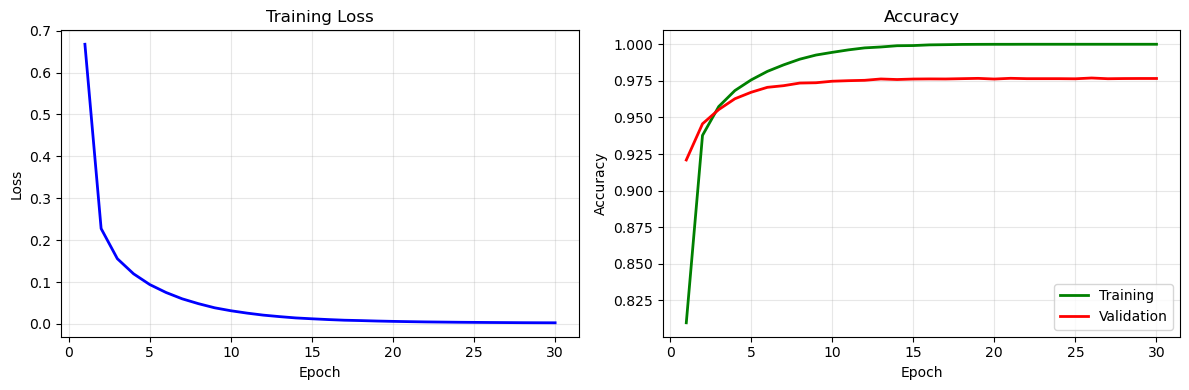

Training completed successfully!


In [6]:
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(range(1, epochs + 1), train_losses, 'b-', linewidth=2)
plt.title("Training Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid(True, alpha=0.3)

plt.subplot(1, 2, 2)
plt.plot(range(1, epochs + 1), train_accs, 'g-', label="Training", linewidth=2)
plt.plot(range(1, epochs + 1), val_accs, 'r-', label="Validation", linewidth=2)
plt.title("Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("Training completed successfully!")

# Predict image 

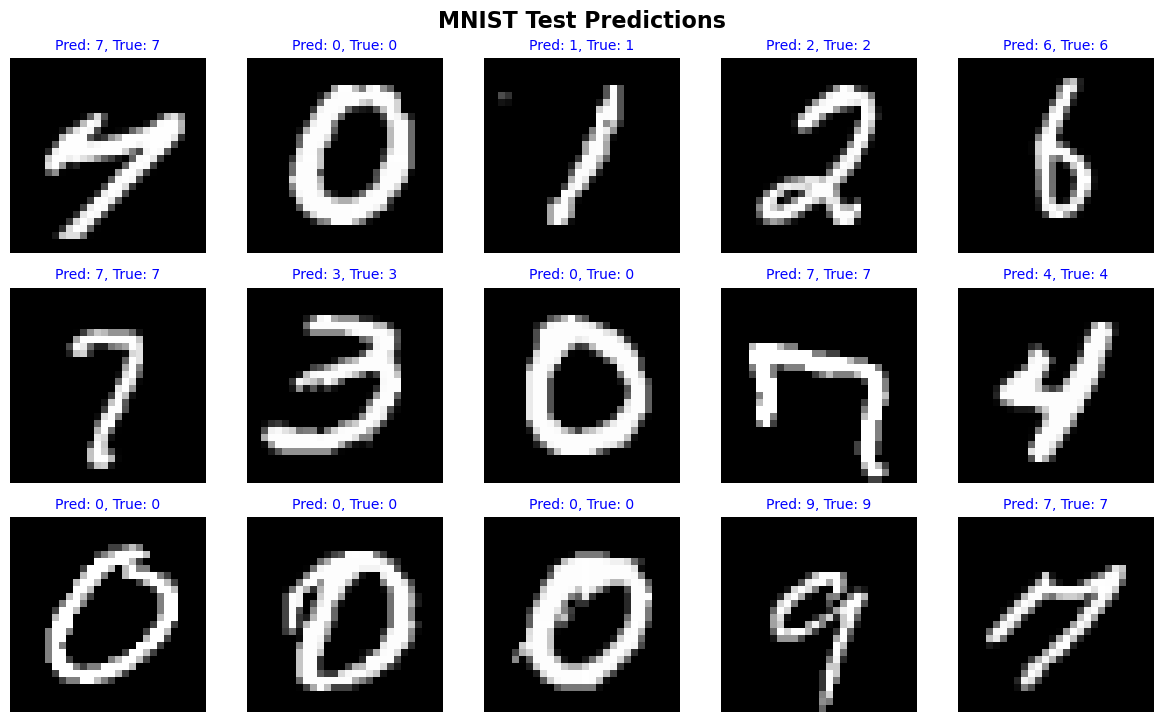

In [ ]:
# Predict and visualize random test images
num_images = 15
indices = np.random.choice(len(X_test), size=num_images, replace=False)

# Set model to evaluation mode (if your model has such a method)
model.eval()

plt.figure(figsize=(12, 12))
for i, idx in enumerate(indices):
    # Get image and label
    image = X_test[idx]                    # Original 2D image for display
    image_flat = X_test_flat[idx]          # Flattened input for model
    true_label = y_test[idx]

    # Forward pass and prediction
    logits = model.forward(image_flat)
    pred_label = np.argmax(logits)

    # Plot
    plt.subplot(5, 5, i + 1)
    plt.imshow(image, cmap='gray')  # Use gray colormap for MNIST
    plt.title(f"Pred: {pred_label}, True: {true_label}", fontsize=10, color='blue' if pred_label == true_label else 'red')
    plt.axis('off')  # Hide axes for cleaner look

plt.suptitle("MNIST Test Predictions", fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

In [8]:
# Save model
filepath = root_path / 'models' / 'mnist_model.pkl'
save_checkpoint(model, optimizer, filepath)